This is a part of the project that developed during **Business Data Analysis** Bootcamp in Rahnama College
The code and results may be developed during the time.

For each bike sharing business being accessible is crucial and because of that they have to prevent stations from becoming empty because not only they will lose the revenue but more importantly their customer trust and reputation will drop drastically. One of the most usable techniques to prevent such a situation is using logistics.  They use some trucks or vans to redistribute the bike in the stations. 


This raises an important question: **Is investing more in logistics worthwhile?** Specifically, does increasing logistics spending to keep stations stocked lead to a reasonable rise in revenue? To answer that we have to answer two side questions 1- What was the revenue loss caused by station emptiness? 2- How much investment is needed to improve logistics? In this notebook we will focus on answering the first question.

As with any question like this, it's best to break this one down into simpler parts to find an answer.




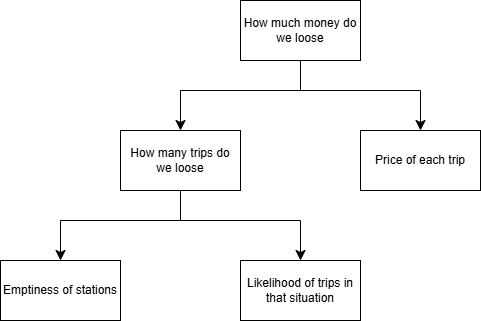

Although bike station saturation could lead to a problem, here we just focus on station emptiness because the station capacities are unknown. Besides, saturation doesn’t directly lead to losing trips.

We’ll start by answering the questions at the leaves and use those answers to work our way up to the root questions.

In this notebook, to keep things simple, I'll just focus on the question and skip some of the data cleaning and the EDA process that I have already done.

**Reading and Downloading the Data**

We are using the public data of Citi bike dataset between  *June 1st 2013* and *January 1st 2014* which you can find in https://s3.amazonaws.com/tripdata/index.html

In [1]:
import pandas as pd
import numpy as np
import os
from matplotlib import pyplot as plt
import gc
import requests, zipfile, io
from datetime import timedelta,datetime

pd.options.display.max_rows=50



In [ ]:

# Download data set files ( from 201306 until 201412) from citibike server into kaggle

# Clear Kaggle Output Folder
!rm -rf /kaggle/working/*

# Sampl Link: https://s3.amazonaws.com/tripdata/2013-citibike-tripdata.zip 

for i in ['2013','2014']:
        
    url=f"https://s3.amazonaws.com/tripdata/{i}-citibike-tripdata.zip" 
    print(url)
    r = requests.get(url)
    z = zipfile.ZipFile(io.BytesIO(r.content))
    z.extractall()

In [ ]:
#Reading Data(local file)
## Put the data into a single file
os.listdir('/kaggle/working')

csv_files=[]
# Some files represent NaN data as the '\N' char.

missing_values= pd._libs.parsers.STR_NA_VALUES
missing_values.add('\\N')

csv_paths=[]
for (root,dirs,files) in os.walk('/kaggle/working',topdown=True):
    
    if  ( '__MACOSX' not in root) and (files): 
        csv_paths.extend( [os.path.join(root,f) for f in files if ".csv" in f])
      
for filename in csv_paths:
        
        csv_files.append(
            pd.read_csv(filename,
                        parse_dates=['starttime','stoptime'],
                        names=["tripduration",
                               "starttime",
                               "stoptime",
                               "start_station_id",
                               "start_station_name",
                               "start_station_latitude",
                               "start_station_longitude",
                               "end_station_id",
                               "end_station_name",
                               "end_station_latitude",
                               "end_station_longitude", 
                               "bikeid",
                               "usertype",
                               "birth year",
                               "gender"],
                        header=0)
        ) 
bicycle=pd.concat(csv_files).reset_index(drop=True)
bicycle=bicycle.drop_duplicates().reset_index(drop=True)
del csv_files
gc.collect()
bicycle.info()

Eeach record contains 15 fields and shows the data of one ride (trip).

In this dataset we have 5 identitis (trip, user, bike,start station,end station).
For each identity we have several properties (column) 

each "User" have usertype (Customer = 24-hour pass or 3-day pass user; Subscriber = Annual Member), birth year and gender (Zero=unknown; 1=male; 2=female).

each "Bike" has a bikeid.

each "Start Station" have start station id, start station name, start station latitude and start statin longitude.

each "End Station" have end station id, end station name, end station latitude and end statin longitude.

each "Trip" has starttime(mm/dd/yyyy hh:mm:ss), stoptime (mm/dd/yyyy hh:mm:ss) and tripduration (Second).

consider this record

In [ ]:
bicycle.query('tripduration == 275 and start_station_id == 498 and bikeid == 18472')


It stated that: a “subscriber” whose “her” year of birth is “1988” grabs a bike with the ID “18472” and starts a trip at “12/1/2014 00:00:43” from station named “Broadway & w 32 St” with the id of “498” located on latitude “40.74854862”, longitude “-73.9880842”. The trip lasts “275” seconds and ends at “12/1/2014 00:05:18” at the station named “E 30 St & Park Ave S” with the ID  “546”,  located at latitude “40.744449” longitude “-73.9830353”


In [ ]:
import folium
from IPython.display import IFrame

# Show HTML file inside the notebook

# Create a map centered on the US
m = folium.Map(location=[40.74193, -73.98129], zoom_start=12)
station_location=bicycle [['start_station_latitude','start_station_longitude']].drop_duplicates()

# Example points



# # Add markers
station_location.apply(lambda x:folium.Marker([x['start_station_latitude'], 
                                               x['start_station_longitude']]).add_to(m),axis=1)
   
    
    # folium.Marker([loc['start_station_latitude'], loc['start_station_longitude']]).add_to(m)

# # Show the map
m.save("map.html")  # Opens in browser
IFrame(src='map.html', width='100%', height='500px')


In [ ]:
# Number of stations 
bicycle['start_station_id'].unique().shape[0]

There are 338 Bike stations spread across Manhattan and parts of Brooklyn boroughs in New York City.
Bellow image shows the relative station's location on the map.

***Data Cleaning***

In [ ]:
should_delete_index=bicycle.query ('bikeid == 19346 and starttime ==@pd.to_datetime ("2013-07-18 08:55:40")').index
#During the EDA process I found that this record should be deleted. It is a redundant record.   
bicycle= bicycle.drop(should_delete_index).reset_index(drop=True)
bicycle=bicycle.astype({'start_station_id':pd.Int16Dtype(),
                        'end_station_id':pd.Int16Dtype(),
                        'bikeid':pd.Int16Dtype(),
                        'start_station_id':pd.Int32Dtype()})
max_starttime= bicycle['starttime'].max()
max_stoptime= bicycle['stoptime'].max()

# Pick the columns we need.
bicycle =  bicycle[['tripduration', 'starttime', 'stoptime', 'start_station_id',
       'end_station_id','bikeid', 'usertype',
       ]].copy()




In [ ]:
# In some records, the end station data is missing (NA). 
# To solve this issue, we will find the next trip for that bike and 
# use its start station as the previous trip’s end station.
bicycle= bicycle.sort_values(by=["bikeid","starttime"]).reset_index(drop=True)
na_end_station_index=  bicycle[bicycle['end_station_id'].isna()].index
bicycle.loc[na_end_station_index,["end_station_id"]]=bicycle.loc[na_end_station_index+1,["start_station_id"]].values

In [ ]:
# In some pair trip records, we can see with a same bikeid, there is an identical statrttime 
#(for example: there are two records which their bikeid == 100 and starttime == 10/12/2013 14:20:30 ).
# From each pair (that have identical starttime and Bikeid) we selecet one, then delete the other.
bicycle= bicycle.sort_values(by=['bikeid','starttime'])

# which two records have the identical starttime and bikeid?
repetitive_indexes = bicycle[bicycle["starttime"].shift(periods=-1)==bicycle["starttime"]].index 
repetitive_indexes=repetitive_indexes.append(repetitive_indexes+1).append(repetitive_indexes+2)
repetitive_indexes=repetitive_indexes.sort_values()
bicycle.loc[repetitive_indexes].head()

In [ ]:
# Does the First one (of the two) has the same end_station with the next trip's start station?
should_be_deleted=bicycle[bicycle.index.isin(repetitive_indexes)&(bicycle["starttime"].shift(periods=-1)==bicycle["starttime"]) &
                                                  (bicycle["start_station_id"].shift(periods=-2)==bicycle["end_station_id"])].index+1 

# If it does, add the second one's index to black list. It should be removed
# Consider the former cell's output, the first two rows show that bikeid == 14734 start a trip from start_station_id ==540
# to end_station_id ==446. bikeid == 14734 start the next trip from 446. both looks good I just keep first one.
remaining_indexes= repetitive_indexes.difference(should_be_deleted)
remaining_data = bicycle.loc[remaining_indexes].copy()
# How about the second ones?
should_be_deleted = should_be_deleted.append(remaining_data[(remaining_data["starttime"].shift(periods=-1)==remaining_data["starttime"]) & 
                                    (remaining_data["start_station_id"].shift(periods=-2)==remaining_data["end_station_id"].shift(periods=-1))].index)


remaining_indexes= remaining_indexes.difference(should_be_deleted)
remaining_data = remaining_data.loc[remaining_indexes].copy()

should_be_deleted =should_be_deleted.append(remaining_data[(remaining_data["starttime"].shift(periods=-1)==remaining_data["starttime"])&
                                                                              (remaining_data['stoptime'].shift(periods=-1)<=remaining_data['stoptime'])].index+1)
remaining_indexes= remaining_indexes.difference(should_be_deleted)
remaining_data = remaining_data.loc[remaining_indexes].copy()

should_be_deleted =should_be_deleted.append( remaining_data[(remaining_data["starttime"].shift(periods=-1)==remaining_data["starttime"])&
                                                                              (remaining_data['stoptime'].shift(periods=-1)>remaining_data['stoptime'])].index)
remaining_indexes= bicycle.index.difference(should_be_deleted)
# remaining_data = remaining_data.loc[remaining_indexes].copy()
bicycle = bicycle.loc[remaining_indexes]
del remaining_data
gc.collect()

A problem that appears in the data is something I like to call a **starttime anomaly** which, describes a condition that the starttime value of a trip is earlier than the stoptime of the previuos trip (for the same bikeid). 

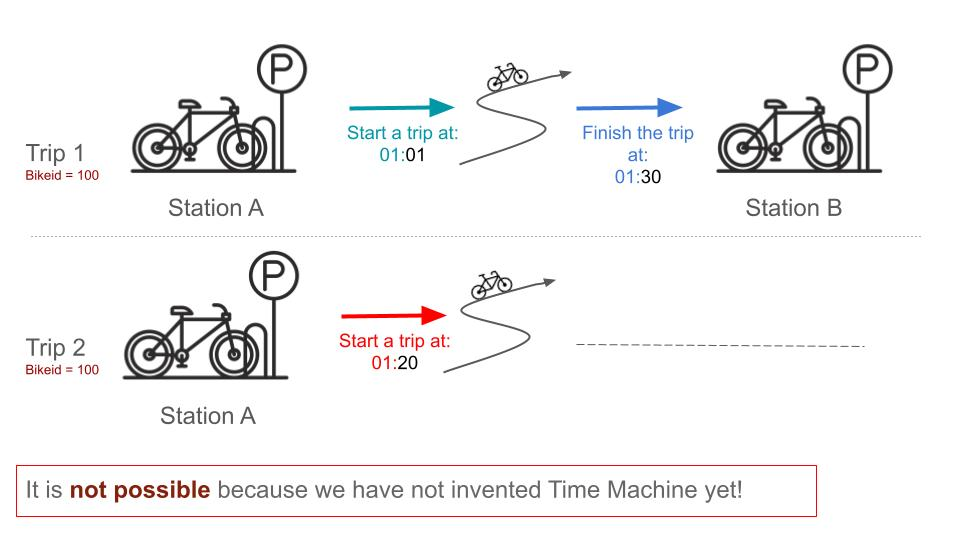
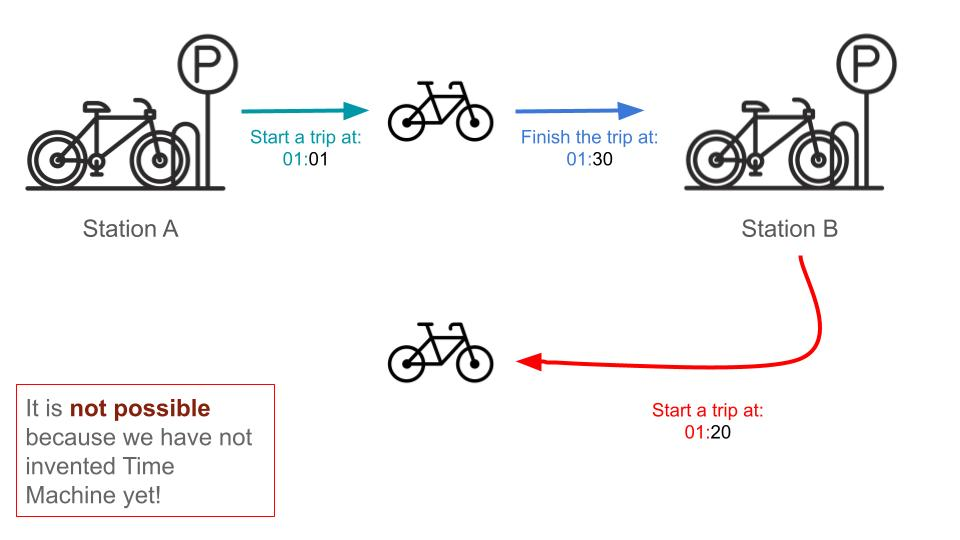

To solve this issue, I should (for each bike) 1-find which trips have ended before they've started the tirp. 2- Edit the stoptimes and bring them before the starttime of the next trip (we will consider the next starttime as correct data) 

Before considering the anomality of "starttime", I would like to examine the "tripdurations" of those with
anomaly time durations and compare their median with other trips. Beacuse if we change the stoptimes we have to update the trip durations.
If two if are similar, changing the trip duration time and correct it is not going to change the overall tripduration distribution.

In [ ]:
# find trips with anomaly starttime 

bicycle.sort_values("starttime",inplace=True)
bicycle.reset_index(drop=True,inplace=True)
all_bike_id=bicycle['bikeid'].unique()

tripduration_time_anomaly_indexes =[]
tripduration_time_anomaly = []
not_anomaly_tripduration =[]
# I know! For loop is not a good move. 
#I'm not gonna use it for vectorized data anymore
for bike_id in all_bike_id:
    that_bike= bicycle[bicycle["bikeid"]==bike_id]
    indexes = that_bike[(that_bike["starttime"].shift(periods=-1)< that_bike["stoptime"])].index
    ok_indexes = that_bike[(that_bike["starttime"].shift(periods=-1)> that_bike["stoptime"])].index
    tripduration_time_anomaly_indexes.extend(indexes+1)
    not_anomaly_tripduration.extend(ok_indexes+1)


tripduration_time_anomaly_data = bicycle.loc[tripduration_time_anomaly_indexes,"tripduration"]
not_anomaly_tripduration_data= bicycle.loc[not_anomaly_tripduration,"tripduration"]
high_bound_anomaly=np.percentile( bicycle.loc[tripduration_time_anomaly_indexes,"tripduration"], 95 )
high_bound_not_anomaly=np.percentile( bicycle.loc[not_anomaly_tripduration,"tripduration"], 95 )
plt.boxplot([not_anomaly_tripduration_data[not_anomaly_tripduration_data < high_bound_not_anomaly],
             tripduration_time_anomaly_data[tripduration_time_anomaly_data<high_bound_anomaly ] ])
plt.xticks([1,2], ["not anomaly tripduration", "anomaly tripduration"])
del tripduration_time_anomaly_data , not_anomaly_tripduration_data
gc.collect()

It looks like both distributions are similar therefore it is ok to correct the tripduration.

In [ ]:
#bicycle stop time correctness


#change the previous stop time to 2 seconds before the next start.

#2 seconds is small enough to avoid conflicts with the start time, but still larger than one second,
# which we've reserved for something else. 
# We could have used the mean of the actual times, but we chose the simpler way.


bicycle.sort_values(['bikeid','starttime'],inplace=True)
bicycle.reset_index(drop=True, inplace=True)
bicycle_anomaly_corrected = bicycle.copy()
indexes=bicycle[(bicycle['starttime'].shift(periods=-1)<bicycle['stoptime'] )&
                (bicycle['bikeid']==bicycle['bikeid'].shift(periods=-1))].index

bicycle_anomaly_corrected.loc[indexes,'stoptime']=bicycle_anomaly_corrected.loc[indexes+1,'starttime'].values-pd.Timedelta(2,'s')

Citibike uses some vehicles (such as vans) to rearrange the bikes (some stations may being used as a 
destination more than origin, and vice versa)
If a station runs out of bicycles (e.g., station Q1, located in a residential area, often becomes empty by 9 AM as people use its bikes to commute to work), it may remains empty for a long time since fewer people return home during the day. To address this, logistics teams typically move bicycles from overcrowded stations, like Q2 in a business area, and redistribute them to empty ones like Q1.

While our dataset doesn’t explicitly include information on these rearrangements, we can infer them. For instance, if a bike ends a trip at one station (e.g., Q2) and later starts a trip from another station (e.g., Q1), it likely indicates that logistics transported the bike between these stations.
To capture this in our dataset, we can add a new record with the following attributes:

    starttime: One second after the last trip ends, as we have no data on the exact time of the logistics transfer.
    stoptime: One second before the next trip begins.
    start_station_id: The station where the bike ends its previous trip.
    end_station_id: The station where the bike starts its next trip.
    bike_id: The unique identifier of the bike.
    usertype: Set to logistics to differentiate these records from regular trip records.
    

![Bicycle-Q1.jpg]
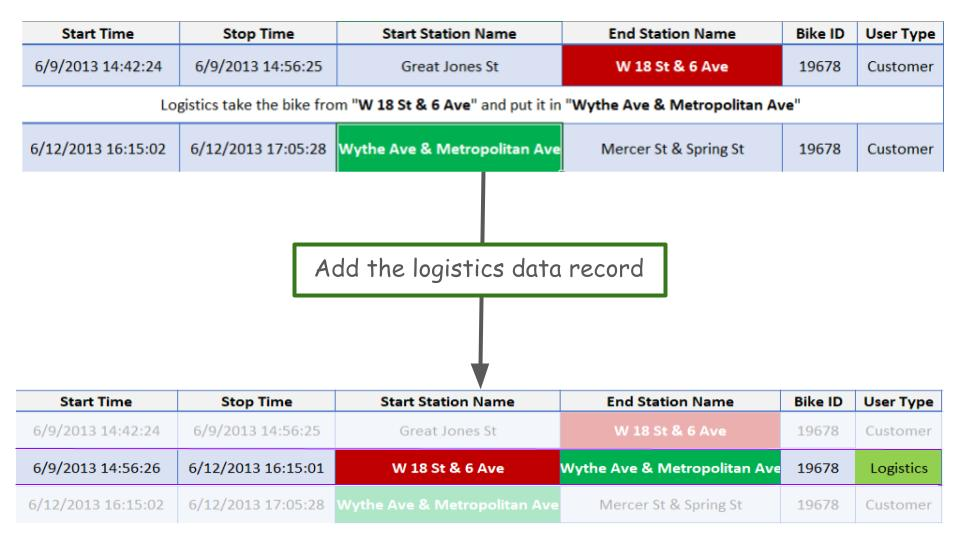

In [ ]:
#Adding logistics
that_bike = bicycle_anomaly_corrected.sort_values(['bikeid','starttime']).sort_index()
# If a bike starts at a station different from where it ended in the prvious trip, I consider it as a logistic move.
indexes=that_bike[(that_bike['start_station_id'].shift(periods=-1)!=that_bike['end_station_id'] )&
                  (that_bike['bikeid'].shift(periods=-1)==that_bike['bikeid'])].index


df_t=pd.DataFrame({'tripduration':pd.Series([0]*len(indexes)),
                         # for simplicity we consiter the logistics start time 1 seconds after the stop time. 
                         # we have no clue when the logistics transfer the bike 
                        'starttime':that_bike.loc[indexes,'stoptime'].values+pd.Timedelta(1,'s'),
                        'stoptime':that_bike.loc[indexes+1,'starttime'].values-pd.Timedelta(1,'s'),
                        'start_station_id':that_bike.loc[indexes,'end_station_id'].values,
                       
                        'end_station_id':that_bike.loc[indexes+1,'start_station_id'].values,
                        
                        'bikeid':that_bike.loc[indexes,'bikeid'].values,
                      
                        'usertype':pd.Series(['logistics']*len(indexes))
                      })
bicycle_with_logistics=pd.concat( [bicycle_anomaly_corrected,df_t])
bicycle_with_logistics.sort_values('starttime',inplace=True)
bicycle_with_logistics.reset_index(drop=True,inplace=True)
del bicycle_anomaly_corrected,df_t
gc.collect()

# Emptiness of stations


Now we want to find out when a station becoming empty. But Before that we need the first and last ride of each bike be added to the dataset.
If a bike being used for the first time, it means before the first trip logistics put it into that station, 
And, if a bike being used for the last time, it means after the last trip, logistics put it out of that station,
so we add the first_logistics record before the first trip and last_logistic record after the last trip for each bike (timely). 


In [ ]:
# Adding first and last logistics records. 

bike_min_time_start=bicycle_with_logistics.groupby('bikeid').agg(starttime=('starttime','min'))
bike_min_time_start.reset_index(inplace=True)
bike_min_time_start_station=bicycle_with_logistics.merge(right=bike_min_time_start,on=['bikeid','starttime'],how='inner')
bike_min_time_start_station
bike_min_time_start_station=bike_min_time_start_station.astype({'starttime':'datetime64[ns]','stoptime':'datetime64[ns]'})

len_bike_min_time_start_station= len(bike_min_time_start_station)
df_t_firsttrip=pd.DataFrame({'tripduration':[0]*len(bike_min_time_start_station),
                'starttime':bike_min_time_start_station['starttime']-pd.Timedelta(2,'s'),
                'stoptime': bike_min_time_start_station['starttime']-pd.Timedelta(1,'s'),
                'start_station_id': [-1]*len(bike_min_time_start_station),
                
                'end_station_id':bike_min_time_start_station['start_station_id'],
                
                'bikeid':bike_min_time_start_station['bikeid'],
                'usertype':pd.Series(['first_logistics']*len_bike_min_time_start_station),
               
                })
bicycle_with_logistics_firsttrip=pd.concat([bicycle_with_logistics,df_t_firsttrip])
del bike_min_time_start , bike_min_time_start_station,df_t_firsttrip
gc.collect()

# find the last ride
bicycle_with_logistics= bicycle_with_logistics.astype({'starttime':'datetime64[ns]','stoptime':'datetime64[ns]'})
bike_max_time_stop=bicycle_with_logistics.groupby('bikeid').agg(stoptime=('stoptime','max'))
bike_max_time_stop.reset_index(inplace=True)
bike_max_time_stop_station=bicycle_with_logistics.merge(right=bike_max_time_stop,on=['bikeid','stoptime'],how='inner')
bike_max_time_stop_station=bike_max_time_stop_station.astype({'starttime':'datetime64[ns]','stoptime':'datetime64[ns]'})

# Like first trip of a bike, for the last trip we are adding the logistics 
 
len_bike_max_time_stop_station= len(bike_max_time_stop_station)
df_t_last=pd.DataFrame({'tripduration':[0]*len(bike_max_time_stop_station),
                
                'starttime':bike_max_time_stop_station['stoptime']+pd.Timedelta(2,'s'),
                'stoptime': bike_max_time_stop_station['stoptime']+pd.Timedelta(3,'s'),
                'start_station_id': bike_max_time_stop_station['end_station_id'] ,
                
               
                'end_station_id':[-1]*len(bike_max_time_stop_station),
               
                'bikeid':bike_max_time_stop_station['bikeid'],
                'usertype':pd.Series(['last_logistics']*len_bike_max_time_stop_station)
                })

# add up all the records in one dataFrame
bicycle_with_logistics_firstlast_trip=pd.concat([bicycle_with_logistics_firsttrip,df_t_last])
bicycle_with_logistics_firstlast_trip=bicycle_with_logistics_firstlast_trip.astype({"starttime":'datetime64[ns]', "stoptime":'datetime64[ns]'})
bicycle_with_logistics_firstlast_trip.reset_index(drop=True,inplace=True)

del bicycle_with_logistics,df_t_last,bike_max_time_stop_station
gc.collect()


Finding when stations become empty.
put start and stop in same column undertneath each other and sort them by station and time 
We are doing this to simplify the solution.

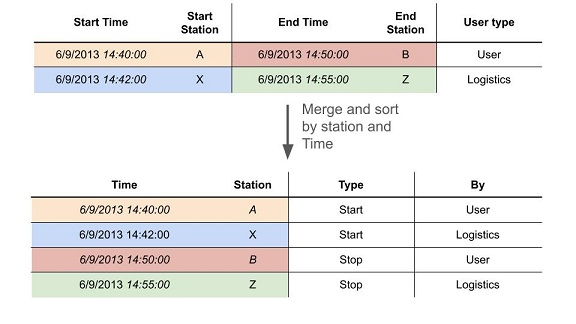
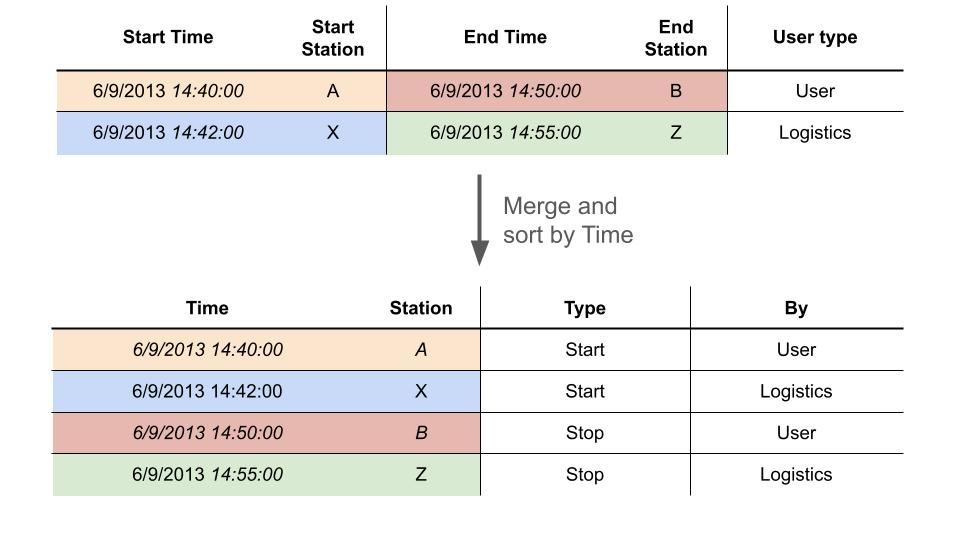
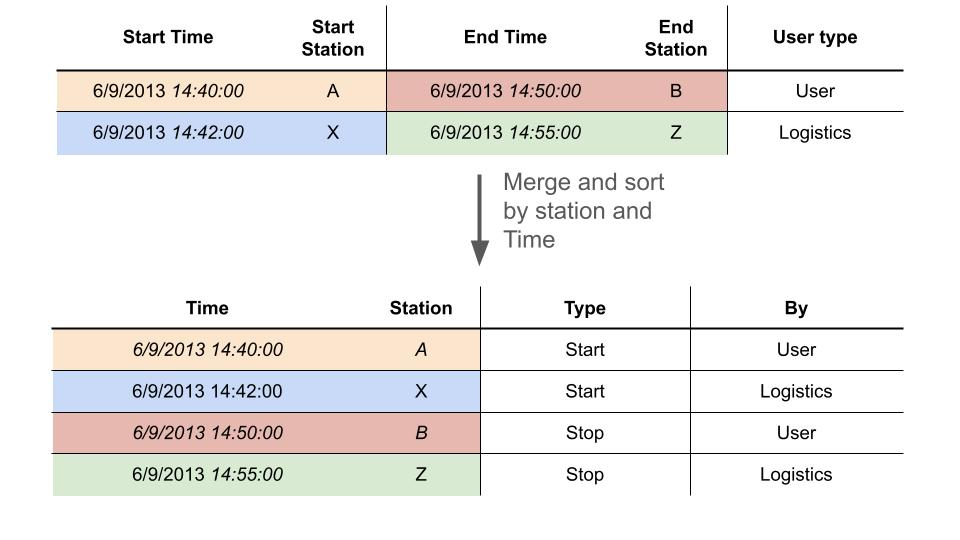

In [ ]:

df_just_start=pd.DataFrame({'time':bicycle_with_logistics_firstlast_trip['starttime'] ,
                        'station':bicycle_with_logistics_firstlast_trip['start_station_id'],
                        'type':pd.Series(['start']*len(bicycle_with_logistics_firstlast_trip)),
                        'by':bicycle_with_logistics_firstlast_trip['usertype']}
                         
                        )
df_just_stop=pd.DataFrame({'time':bicycle_with_logistics_firstlast_trip['stoptime'] ,
                        'station':bicycle_with_logistics_firstlast_trip['end_station_id'],
                        'type':pd.Series(['stop']*len(bicycle_with_logistics_firstlast_trip)),
                        'by':bicycle_with_logistics_firstlast_trip['usertype']}
                     )

df_together_firstlasttrip=pd.concat([df_just_stop,df_just_start],ignore_index=True)
df_together_firstlasttrip.sort_values('time',inplace=True)
df_together_firstlasttrip.reset_index(drop=True,inplace=True)
df_together_firstlasttrip= df_together_firstlasttrip.astype({'time':'datetime64[ns]'})

Set -1 for start action and +1 for stop action
Start’ means a bike has been taken from a station, and ‘stop’ means a bike has been returned to a station.

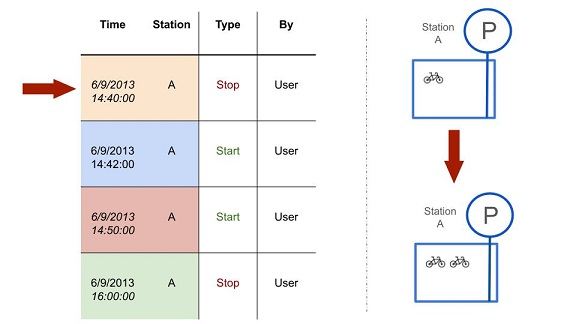
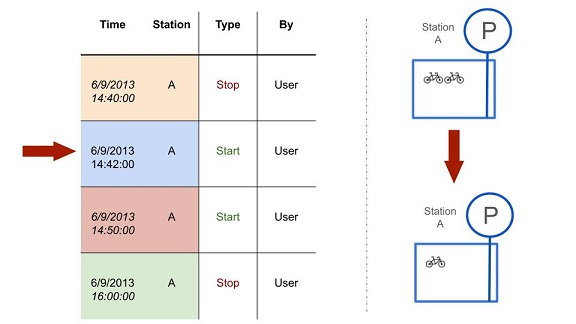
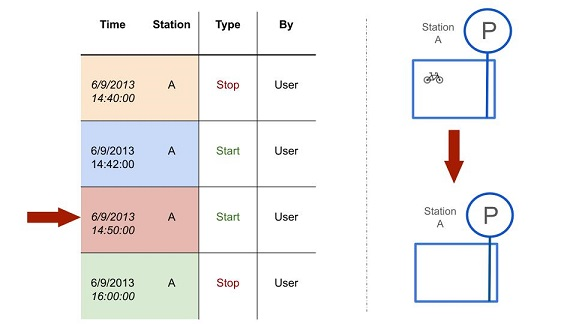
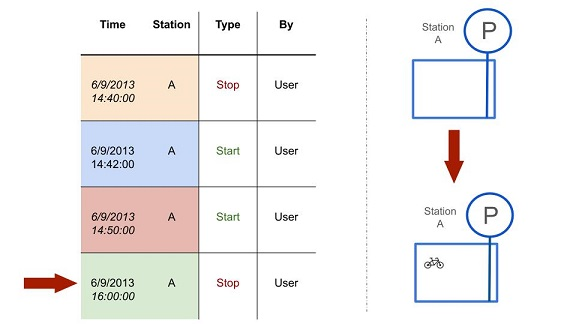
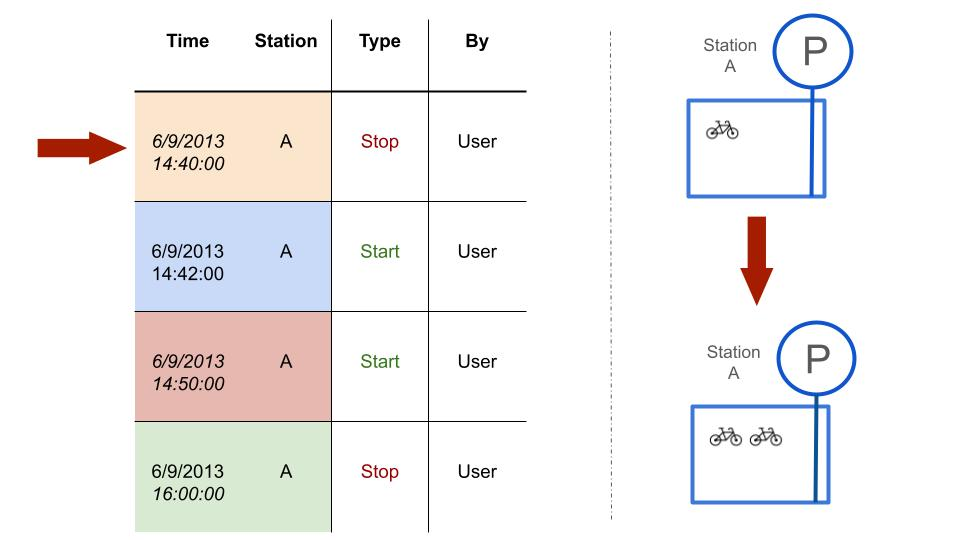
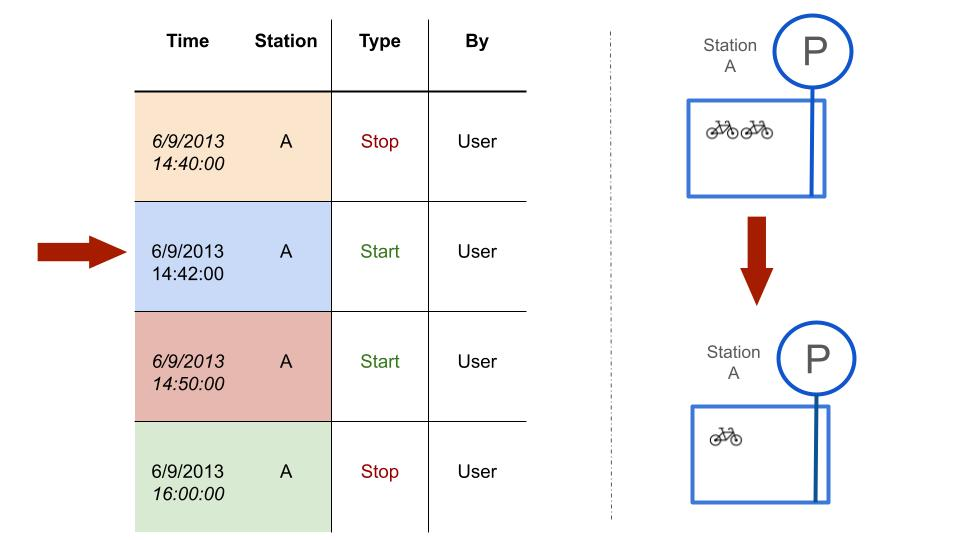
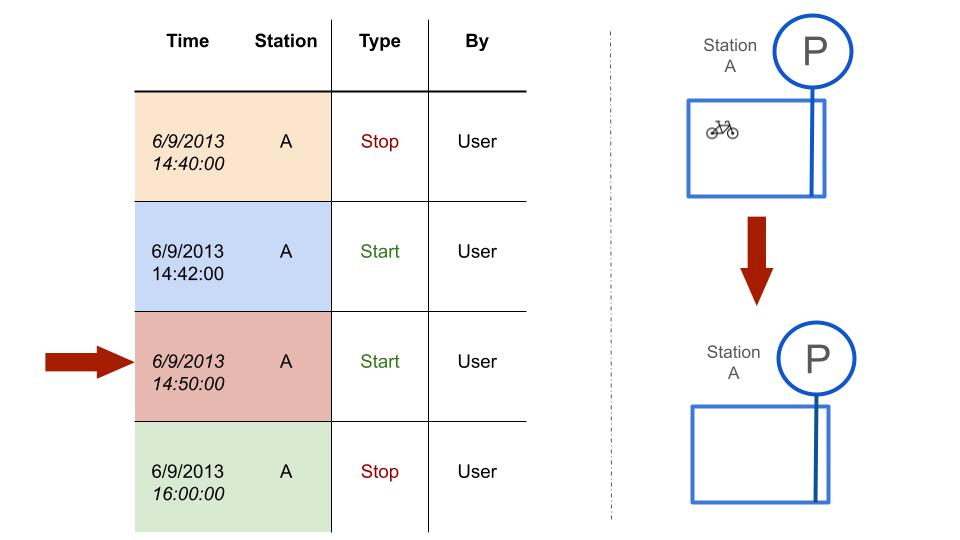
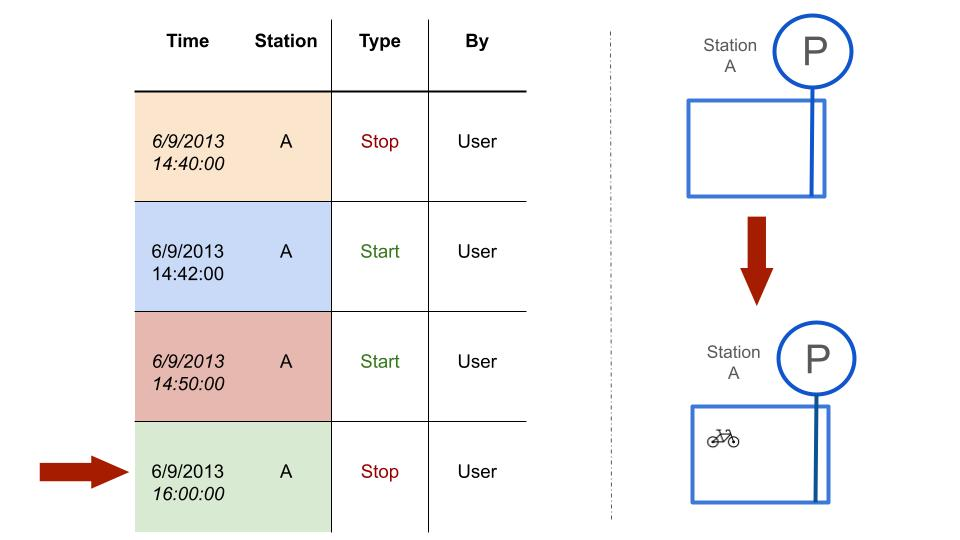
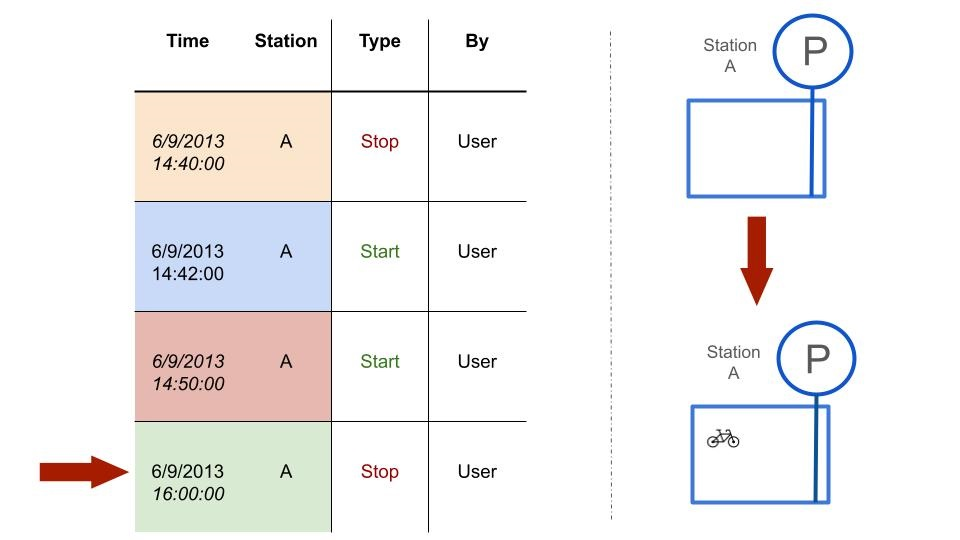
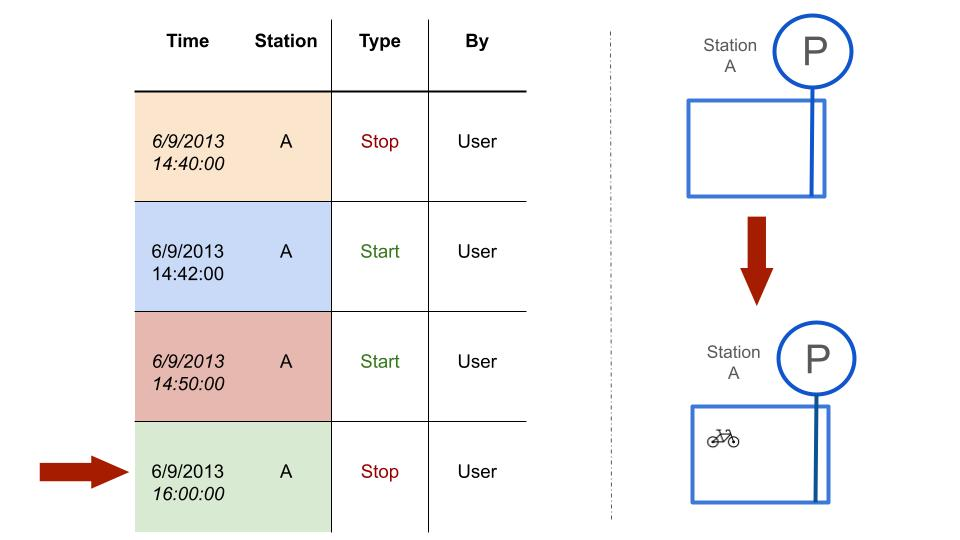

In [ ]:

df_together_firstlasttrip['in_out_flag']=-1*(df_together_firstlasttrip['type']=='start').astype("int64") + (df_together_firstlasttrip['type']=='stop').astype("int64")
calculated_in_out = df_together_firstlasttrip[["station","in_out_flag"]].groupby('station').cumsum(numeric_only=True)
df_together_firstlasttrip=calculated_in_out.join(
    df_together_firstlasttrip,rsuffix="r",lsuffix="l"
    ).rename(
        columns={"in_out_flagr":'in_out_flag',"in_out_flagl":"calculated_in_out"}
        ).drop(
    index=df_together_firstlasttrip[df_together_firstlasttrip['station']==-1].index 
    )

# harvest empty stations
# we previously set the input logistics time to 1 second before the start time 
# (like 1 second after logistics put the bike into a station, it would be taken by a person)
# but it may be wrong. so we remove those empty times that may be false. 
# (station A became empty from 2:00:00 AM. at 4:00:00 AM the logistics put a bike into the station and at 4:00:01 
# a user took the bike and started a trip. we remove this empty time from our empty stations data because 
# we have no idea how much time this station remained empty and  when the logistics put the bike in the station A. 
# so why we set the logistics end trip to 1 second before the start time of the next trip? 
# We want to add a data record for each logistics activities the problem is we have no idea when how the logistics
# algorithm works and when exactly they redistribute the bikes. 
# So, to simplify, we just fill the start and end times with values that ensure they do not cause any anomalies in data.)
empty_data_stations=[]

that_station=df_together_firstlasttrip.sort_values(['station','time']).reset_index(drop=True).copy()

that_station['diff0']=that_station[['station','time']].groupby('station').diff()

t=pd.Timedelta(2,'s')  # we set 2 sec for 
index_be_zero=that_station[(that_station['diff0']<=t)&(that_station['calculated_in_out']==0)].index
# logistic puts the bike in the station (and took by a customer), or it is the last logistics, 
# or logistics takes the bike (we set the taking time one sec after previous ride) 

index_be_zero_minus_1=index_be_zero-1 # trips that put the "last" bike into the station

# that_station.loc[index_be_zero_minus_1].to_csv("index_minus_1.csv",index=False)
index_del=index_be_zero_minus_1.union(index_be_zero_minus_1-1) 
# Logistics often place multiple bikes at a station. 
# If a customer starts a trip (removing one bike) leaving the station empty, 
# which that bike they take was previously placed there by logistics, 
# it suggests that there were initially more bikes placed in the station by logistics.

that_station_level_1= that_station.loc[~that_station.index.isin(index_del) ]
that_station_level_2=that_station_level_1[~((that_station_level_1['by']=='logistics')|(that_station_level_1['by']=='last_logistics'))|
                                            ~(that_station_level_1['in_out_flag']==-1) ].copy()
that_station_level_2= that_station_level_2.sort_values(['station','time'])

# filter ones that are both logistics and -1. solve the boolean formula
# 1- The only situation matters is when the station is empty.
#2- We consider it impossible that logistics makes the station empty
#then we remove those in the top
not_equal_station_index=that_station_level_2['station'].ne(that_station_level_2['station'].shift(-1))
that_station_level_2['diff_time'] = abs(that_station_level_2['time'].diff(-1).dt.total_seconds())/60
that_station_level_2 = that_station_level_2.loc[~not_equal_station_index].copy()
that_station_level_3=that_station_level_2[that_station_level_2['calculated_in_out']==0].copy()
# diff (-1) beacause we want to know the amount of time does the station remain empty.
that_station_level_3=that_station_level_3.drop(['calculated_in_out','type','by','in_out_flag','diff0'],axis=1)
# in each hour how much time (per minute) one station has been empty? We are trying to answer this question

empty_station_data_hour=that_station_level_3.groupby(
    [pd.Grouper(key='time',freq='1h'),'station']
    ).agg(
        total_empty=('diff_time','sum')
        ).reset_index()
del df_just_start,df_just_stop,that_station,that_station_level_1,that_station_level_2
gc.collect()

In [ ]:
empty_station_data_month= empty_station_data_hour.drop(empty_station_data_hour[((empty_station_data_hour['total_empty']==0)|
                                                                                (empty_station_data_hour['total_empty']>2880))].index)
# If the total empty time exceeds 2 days, the reason is likely something other than just a lack of bikes, like station renovation 
# it's rare but sometimes start and stop a trip will be happened in the same time. we will remove it from our data. 
empty_station_data_month.rename({"total_empty":"emptiness"},inplace=True,axis=1)

# some empty time may be longer than one hour. so we spread it in several hours 
# (to separate the rush hours from others. enhance the calculation precision )
l=[]
empty_station_data_month=empty_station_data_month.astype({'emptiness':'int32'})

for row in range(len(empty_station_data_month)):
    c=empty_station_data_month.iloc[row]
 
    if c['emptiness']> 60 : 
        df_temp_empty=pd.DataFrame(
            {'empty_time':pd.concat(
                [pd.Series(
                    pd.date_range(
                        start=c['time'], periods=c['emptiness']//60, freq='1h'
                        )
                    ) ,
                pd.Series(
                    c['time']+pd.Timedelta(
                        c['emptiness']//60,'h'
                        )
                    )
                ]
                ).reset_index(drop=True),
            'station':pd.Series(
                c["station"].repeat(
                    c['emptiness']//60+1
                    )
                ).reset_index(drop=True),
            'emptiness':pd.concat(
                [pd.Series(
                    [60]*(int(c['emptiness']//60))
                    ) , 
                 pd.Series(
                        [c['emptiness']%60]
                        )
                 ]
                ).reset_index(drop=True)
            }
            ,index=np.arange(int(c['emptiness']//60)+1))
    elif c['emptiness']<= 60:
        df_temp_empty=pd.DataFrame(
            {'empty_time':c['time'],
             'station':c['station'],
             'emptiness':c['emptiness']
            },index=[0]
        )
    l.append(df_temp_empty)
df_empty_sum_hour_widened=pd.concat(l) 

# generate these to facilitate the merge process
df_empty_sum_hour_widened.rename({'empty_time':'time'},axis=1,inplace=True)
df_empty_sum_hour_widened['hour']=df_empty_sum_hour_widened['time'].dt.hour
df_empty_sum_hour_widened['year']=df_empty_sum_hour_widened['time'].dt.year
df_empty_sum_hour_widened['month']=df_empty_sum_hour_widened['time'].dt.month
df_empty_sum_hour_widened['weekend']=df_empty_sum_hour_widened['time'].dt.weekday > 4
del empty_station_data_month,l
gc.collect()

We want to calculate the trip that been lost (potential trip or trips that if the station was not empty, it would be happend. 
But now, because the station was empty, the trip being lost)
For that, we have to have 2 data: 
**1-** the (median) number of trips  happen regularly in "that" station at "that" 
time (part of the day) and "that" month
e.g. the median of number of trips at 9:00 from station id = 10 during April
**2-** the duration of station's emptiness (in minute)
then we could show : "if this station would not be empty, how many trips would be occured"

# Likelihood of trip based on situation

Find the median trip in each hour,each station,and each month 
weekend and weekdays also separated

![Bicycle-Q1 (8).jpg]

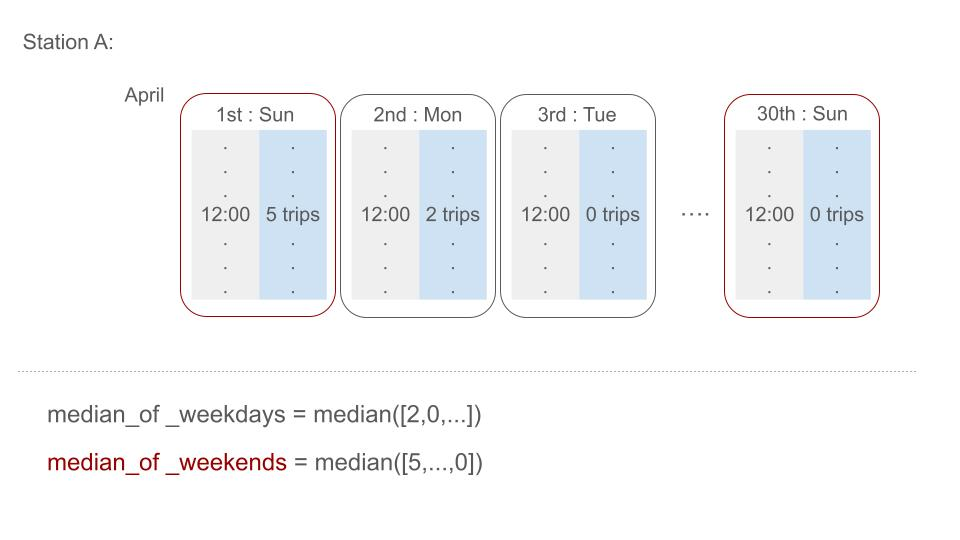
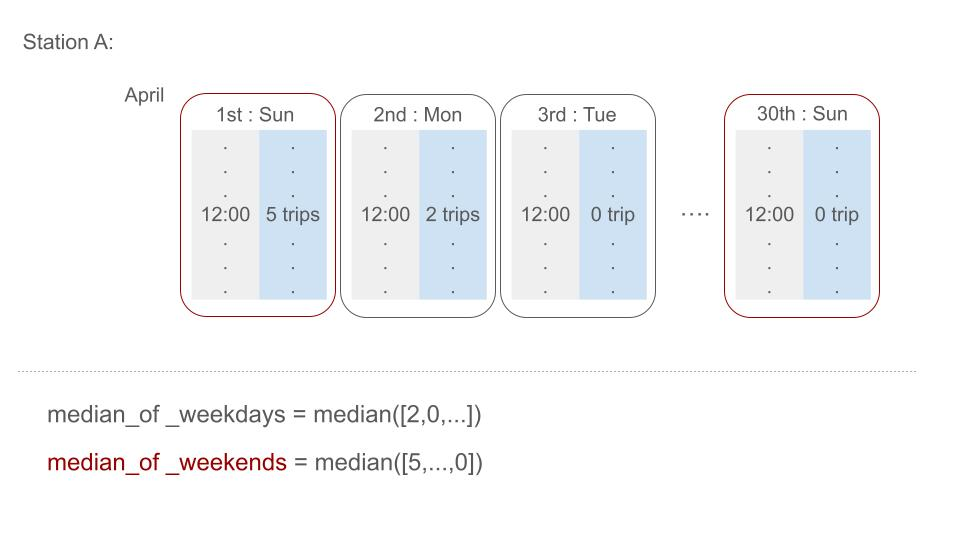

In [ ]:
bicycle= bicycle_with_logistics_firstlast_trip[(bicycle_with_logistics_firstlast_trip['usertype']=='Subscriber')|
                                               (bicycle_with_logistics_firstlast_trip['usertype']=='Customer')].astype({'starttime':'datetime64[ns]',
                                                                                                                        'stoptime':'datetime64[ns]'})

total_station_trip = bicycle.groupby([pd.Grouper(key='starttime',freq='1h'),'start_station_id']).agg(
                                                                                        total_trip_duration=('tripduration','size'))
total_station_trip= total_station_trip.reset_index().sort_values('starttime')
total_station_trip['starttime']=pd.to_datetime( total_station_trip['starttime'].dt.strftime('%Y-%m-%d %H'))
total_station_trip['hour']=total_station_trip['starttime'].dt.hour # it is useful in the future for merging 
total_station_trip['weekend']=total_station_trip['starttime'].dt.weekday > 4
total_station_trip['hour_cat'] =total_station_trip['hour']//3 +1
df_empty_sum_hour_widened['hour_cat']= df_empty_sum_hour_widened['hour']//3+1

In [ ]:

def weekend_median_calculator(block):
    try:
        # at most we're gonna get 9 days of weekends. if we have no trips in a day no record stated 
        #thats why we are filling in 0s to the days we have no trips to make the median works properly
         
         return  block._append( 
                pd.Series(np.zeros(9-len(block))),
                ignore_index=True
            ).median()
    except:
         return  block._append( 
                pd.Series(np.zeros(10-len(block))),
                ignore_index=True
            ).median()
        
def weekdays_median_calculator(block):
        
        try:
            return block._append( 
                   pd.Series(np.zeros(22-len(block))),
                   ignore_index=True
                   
                   ).median()
        except:
            return block._append( 
                   pd.Series(np.zeros(23-len(block))),
                   ignore_index=True
                   
                   ).median()

def hour_cat_mean_calculator(cat):
    
    return  cat._append( 
                pd.Series(np.zeros(3-len(cat))),
                ignore_index=True
                
                ).mean()
        


median_station_trip_temp=total_station_trip.groupby(
    [pd.Grouper(key='starttime',freq='1d'),
     'hour_cat',
     'start_station_id',
     'weekend']
    ).agg(
        mean_hour_cat=(
            'total_trip_duration',
            hour_cat_mean_calculator
            )
        ).reset_index()
    
median_station_trip_weekend = median_station_trip_temp.query('weekend==True').groupby(
                [pd.Grouper(
                    key='starttime',
                    freq='1m'
                    ),
                    'hour_cat',
                    'start_station_id'
                ]
                ).agg(
                    hour_cat_median=(
                        'mean_hour_cat',
                        weekend_median_calculator
                    )
                ).reset_index()
median_station_trip_weekday = median_station_trip_temp.query('weekend==False').groupby(
                [pd.Grouper(
                    key='starttime',
                    freq='1m'
                    ),
                    'hour_cat',
                    'start_station_id'
                ]
                ).agg(
                    hour_cat_median=(
                        'mean_hour_cat',
                        weekdays_median_calculator
                    )
                ).reset_index()
median_station_trip_weekday['weekend']=pd.Series([False]*len(median_station_trip_weekday))
median_station_trip_weekend['weekend']=pd.Series([True]*len(median_station_trip_weekend))
median_station_trip = pd.concat([median_station_trip_weekend , median_station_trip_weekday])
         


median_station_trip.rename({'starttime':'time','start_station_id':'station'},axis=1,inplace=True)

median_station_trip['time']=pd.to_datetime( median_station_trip['time'].dt.strftime('%Y-%m-01'))
median_station_trip['month']=median_station_trip['time'].dt.month
median_station_trip['year']=median_station_trip['time'].dt.year


In [ ]:
df_lost_trip=median_station_trip.merge(
    right=df_empty_sum_hour_widened.drop(
        ['time','hour'], axis=1
     ),
    on=['hour_cat','month','year','station','weekend'],how='right'
 )

# the /60 is necessary. if median is 1 ( 1 trip in this hour ) and emptiness is equal to 60/60=1 then we've lost 1 trip
df_lost_trip['minute_lost_potential_median']=df_lost_trip['hour_cat_median']*(df_lost_trip['emptiness']/60)

wait a sec! OK we find the amount of station emptiness but do we have extra bikes? 
If the number of idle bikes are not enough so the logistics developement would be fruitless

In [ ]:
# busyness of bikes


#As we we previously add last logistics to our data set therefore, in November and December we have too many 'last_logistics'.
# So we should change them and make them like other months

bicycle_with_logistics_firstlast_trip=bicycle_with_logistics_firstlast_trip.astype({"starttime":"datetime64[ns]","stoptime":"datetime64[ns]"})
bicycle_with_logistics_last_corrected=bicycle_with_logistics_firstlast_trip.copy()
indexes_nov= bicycle_with_logistics_last_corrected[(bicycle_with_logistics_last_corrected['starttime']>=pd.to_datetime('2013-11-01'))&
                                               (bicycle_with_logistics_last_corrected['starttime']<=pd.to_datetime('2013-12-01'))&
                                                                            (bicycle_with_logistics_last_corrected['usertype']=='last_logistics')].index
indexes_dec= bicycle_with_logistics_last_corrected[(bicycle_with_logistics_last_corrected['starttime']>=pd.to_datetime('2013-11-01'))&
                                               (bicycle_with_logistics_last_corrected['starttime']<=pd.to_datetime('2013-12-01'))&
                                                                            (bicycle_with_logistics_last_corrected['usertype']=='last_logistics')].index
choosed_indexes_nov= np.random.choice(indexes_nov ,int(len(indexes_nov)*0.8),replace=False)
choosed_indexes_dec= np.random.choice(indexes_dec ,int(len(indexes_dec)*0.93),replace=False)

bicycle_with_logistics_last_corrected.loc[choosed_indexes_nov,'usertype']='logistics'
bicycle_with_logistics_last_corrected.loc[choosed_indexes_dec,'usertype']='logistics'

In [ ]:
bicycle_with_logistics_firstlast_trip= bicycle_with_logistics_firstlast_trip.reset_index(
    names=['tripid'])[['tripid',
                       'tripduration',
                       'starttime',
                       'stoptime',
                       'start_station_id',
                       'end_station_id',
                       'bikeid',
                       'usertype']].reset_index(drop=True)


In [ ]:
# bicycle_with_logistics_firstlast_trip2['starttime']=pd.to_datetime( bicycle_with_logistics_firstlast_trip2['starttime'].dt.strftime('%Y-%m-%d %H'))

bicycle_with_logistics_firstlast_trip.loc[
    bicycle_with_logistics_firstlast_trip['usertype']=='first_logistics','starttime'
                                            ] =  pd.to_datetime('2013-06-01 00:00:00')
bicycle_with_logistics_firstlast_trip.loc[
    bicycle_with_logistics_firstlast_trip['usertype']=='last_logistics','stoptime'
                                            ] =  max_stoptime + pd.Timedelta(1, 'h')

bicycle_with_logistics_firstlast_trip['tripduration']= (bicycle_with_logistics_firstlast_trip['stoptime']-bicycle_with_logistics_firstlast_trip['starttime']).dt.seconds //3601+1
bicycle_with_logistics_firstlast_trip['time_to_add']= pd.Series([1]*bicycle_with_logistics_firstlast_trip.shape[0])
#The next commands calculate the hours that a bike was busy. if the trip was more than an hour, it expands the trip to each hour
bicycle_with_logistics_firstlast_trip = bicycle_with_logistics_firstlast_trip.loc[
    bicycle_with_logistics_firstlast_trip.index.repeat(bicycle_with_logistics_firstlast_trip['tripduration'])]
bicycle_with_logistics_firstlast_trip['time_to_add']=bicycle_with_logistics_firstlast_trip[['tripid','time_to_add']].groupby(['tripid']).cumsum()
bicycle_with_logistics_firstlast_trip['time_to_add']=bicycle_with_logistics_firstlast_trip['time_to_add'].apply(lambda x:pd.Timedelta(x-1,'h'))
bicycle_with_logistics_firstlast_trip['starttime']=bicycle_with_logistics_firstlast_trip['starttime']+bicycle_with_logistics_firstlast_trip['time_to_add']
bicycle_with_logistics_firstlast_trip['starttime'] = bicycle_with_logistics_firstlast_trip['starttime'].dt.strftime("%Y-%m-%d %H").astype('datetime64[ns]')
bicycle_with_logistics_firstlast_trip= bicycle_with_logistics_firstlast_trip.drop_duplicates(subset= ['bikeid','starttime'],keep='last')
# bicycle_with_logistics_firstlast_trip2[:5]
df_bike_usage_report = bicycle_with_logistics_firstlast_trip[['starttime','bikeid']].rename(columns= {'starttime':'time'})
df_bike_usage_report.loc[:,'busy']=pd.Series([1]* df_bike_usage_report.shape[0])
df_bike_usage_report = df_bike_usage_report.sort_values('time').reset_index(drop=True)

busy_bikes_all_time= df_bike_usage_report[['time','busy']].groupby(pd.Grouper(key='time',freq='1h')).sum().reset_index()
busy_bikes_all_time['bike_numbers'] =pd.Series([df_bike_usage_report['bikeid'].unique().shape[0]]*busy_bikes_all_time.shape[0])

busy_bikes_all_time['bike_available']= busy_bikes_all_time['bike_numbers']- busy_bikes_all_time['busy']
# in 2013-06-01 00:00:00 has more "busy" than total number of bikes. Because some bikes has both first_logistics and normal trip.
# run this to show you one sample. bicycle_with_logistics_firstlast_trip_t.query('starttime < @pd.to_datetime("2013-06-01 01:00:00") and bikeid == 16649')
# It may makes the available number of bikes to negative. Its fine! not gonna change the result so much. we can leave it to be negative.

busy_bikes_all_time['bike_available'].median() # The number is the median of numbers of available bike (idle bike) that are not currently using in that time


Yes we have enough bikes. 

**It’s worth mentioning that, to simplify the solution we ignored two questions: 1-Are the idle bikes located in nearby stations? 2-Is the bikes’ residual time long enough? Aside from defining what 'nearby station' is, idle bikes should be reasonably accessible otherwise, it does not matter how many we have.**

# Cost of each trip

We're trying to figure out the price of each trip so we can estimate how much money is lost when trips don’t happen. To do that, we're using the general multiplication rule. Basically, we're estimating the probability of a trip by asking: if a trip starts, how likely is it that a Subscriber takes it? And how likely is it that the trip goes over the time limit?
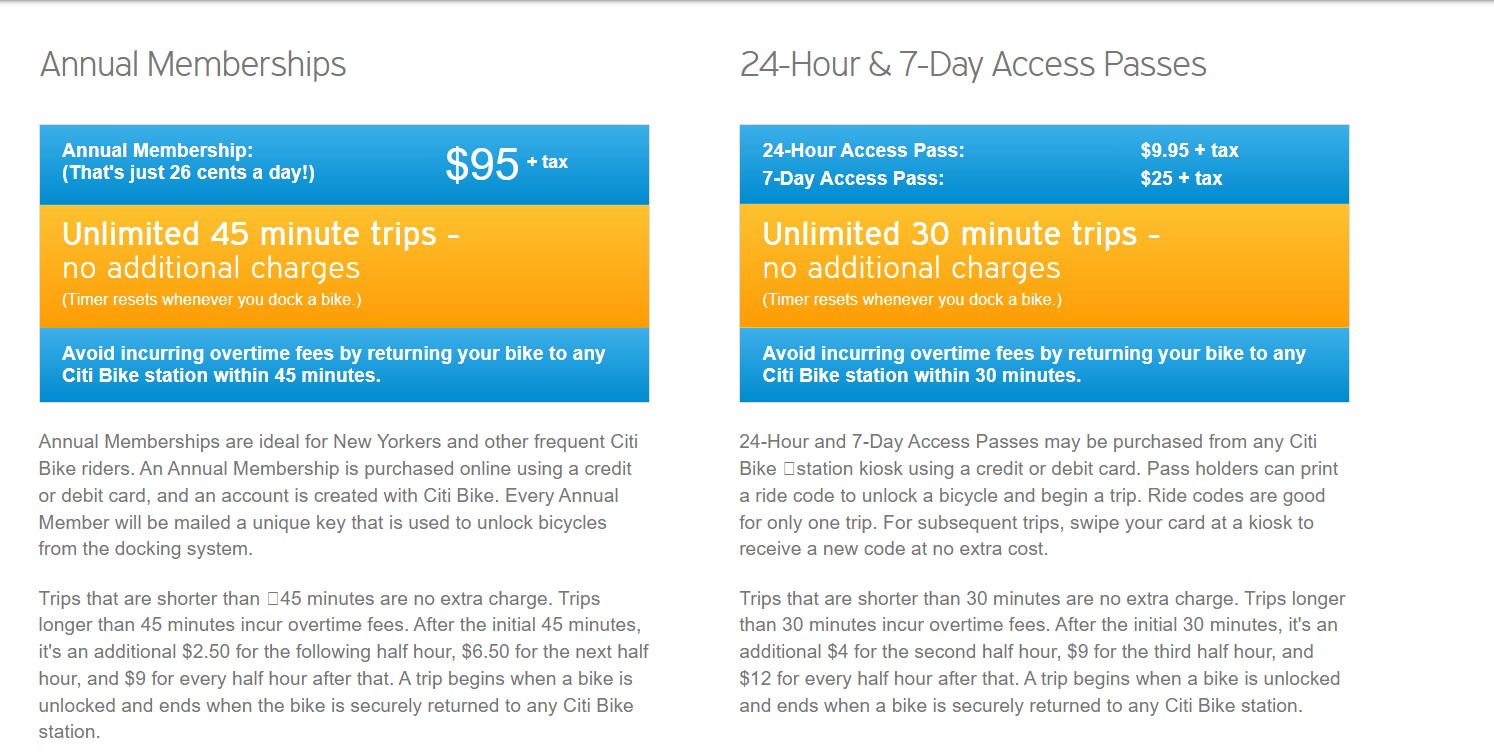

To begin lets see the price plan of Citibike

Annual Membership: $95
Trips that are shorter than 45 minutes are no extra charge. Trips longer than 45 minutes incur overtime fees. After the initial 45 minutes, it's an additional $2.50 for the following half hour, $6.50 for the next half hour, and $9 for every half hour after that. A trip begins when a bike is unlocked and ends when the bike is securely returned to any Citi Bike station.

24-Hour Access Pass:$9.95

7-Day Access Pass:$25

Trips that are shorter than 30 minutes are no extra charge. Trips longer than 30 minutes incur overtime fees. After the initial 30 minutes, it's an additional $4 for the second half hour, $9 for the third half hour, and $12 for every half hour after that. A trip begins when a bike is unlocked and ends when a bike is securely returned to any Citi Bike station.

source: https://web.archive.org/web/20130729085249/http://www.citibikenyc.com/pricing

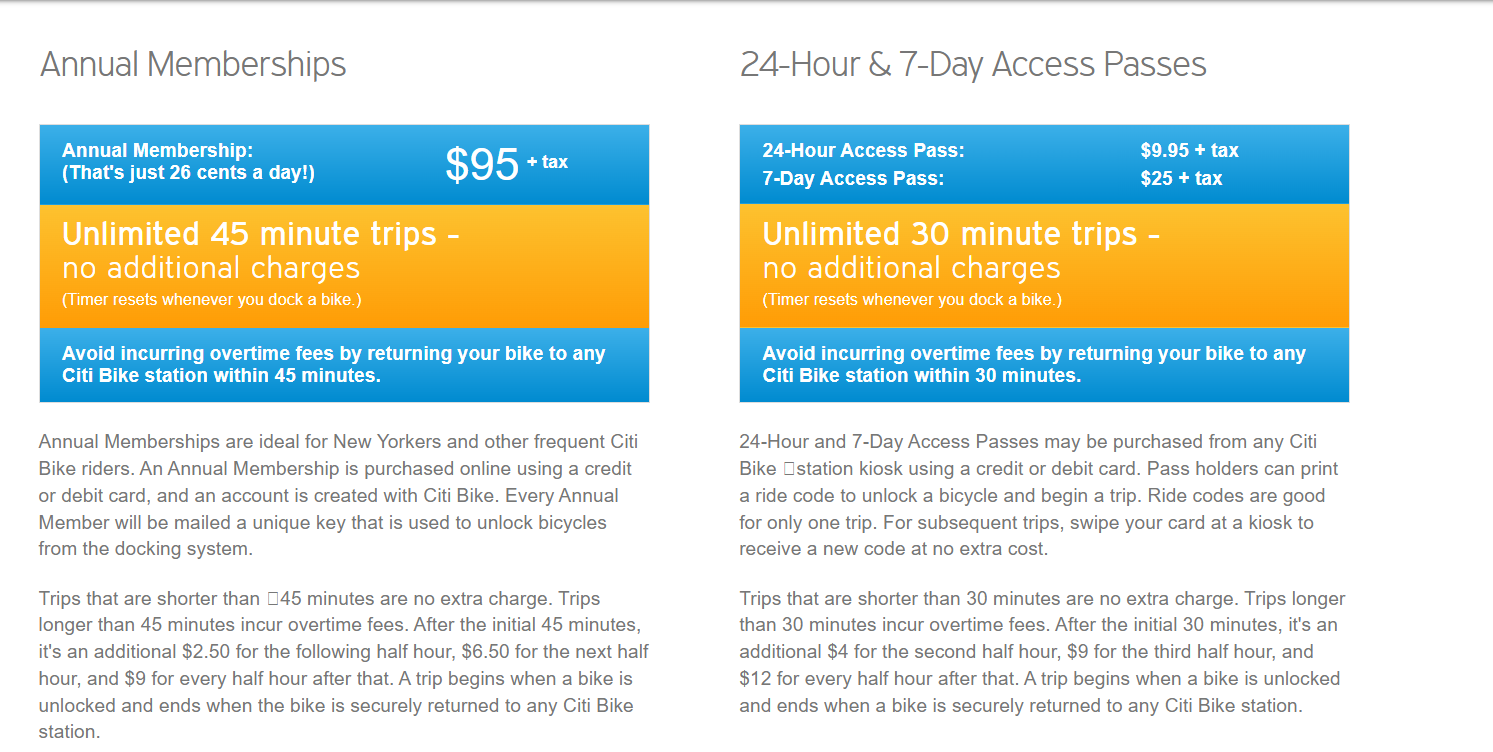

For example calculating the extra charge for an Annual subscriber would be like:
A 150 min trip costs: 9+9+9+6.5+2.5 = 36$  Extra charge
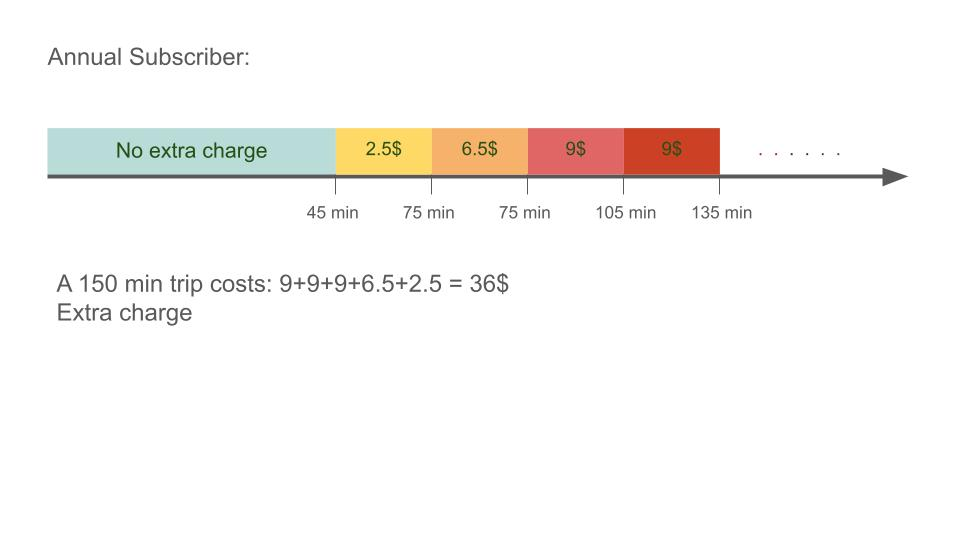
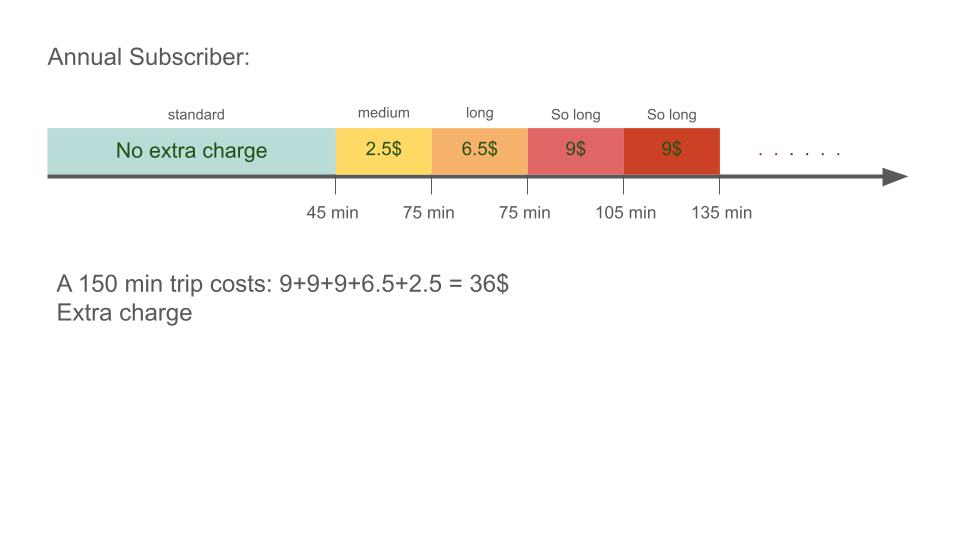

In [ ]:
### find the the price of each trip
sub_percent=[]
sub_percent_long_ride=[]
sub_profit_each_long_ride=[]
sub_price_per_subscriber=[]
cust_percent_long_ride=[]
cust_profit_per_long_ride=[]
bicycle['yearmonth']=bicycle['starttime'].dt.strftime('%Y%m').astype(np.int64)
#we consider the trip longer than 43200 seconds (12 hours) an outlier
df_t = bicycle.query('tripduration < 43200').copy()
df_sub= df_t.query('usertype == "Subscriber" ').copy()
df_cust = df_t.query ('usertype == "Customer"').copy()
# The portion of trips done buy Subscribers
sub_percent = df_sub.groupby('yearmonth').size() / df_t.groupby('yearmonth').size()
# The portion of medium ride (over 45 min) to all trips done by Subscibers 
sub_percent_standard_ride = df_sub.query('tripduration <= (45*60)').groupby('yearmonth').size() / df_sub.groupby('yearmonth').size()
sub_percent_medium_ride = df_sub.query('tripduration > (45*60) and tripduration <=(75*60)').groupby('yearmonth').size() / df_sub.groupby('yearmonth').size()
sub_percent_long_ride = df_sub.query('tripduration > (75*60) and tripduration <=(105*60)').groupby('yearmonth').size() / df_sub.groupby('yearmonth').size()
sub_percent_solong_ride = df_sub.query('tripduration > (105*60)').groupby('yearmonth').size() / df_sub.groupby('yearmonth').size()


cust_percent_standard_ride = df_cust.query('tripduration <= (30*60)').groupby('yearmonth').size()/ df_cust.groupby('yearmonth').size()
cust_percent_medium_ride = df_cust.query('tripduration > (30*60) and tripduration <= (60*60)').groupby('yearmonth').size()/ df_cust.groupby('yearmonth').size()
cust_percent_long_ride = df_cust.query('tripduration > (60*60) and tripduration <=(90*60)').groupby('yearmonth').size()/ df_cust.groupby('yearmonth').size()
cust_percent_solong_ride = df_cust.query('tripduration > (90*60) ').groupby('yearmonth').size()/ df_cust.groupby('yearmonth').size()
                                      
# The profit of extra time(after 45 min) in each ride ( all profit devided by all long trips done by Subscribers)
sub_profit_each_medium_ride = 2.5
sub_profit_each_long_ride = 6.5

sub_extra_for_solong_ride=9
# The profit of extra time(after 105 min) in each ride ( all profit devided by all medium trips done by Subscribers)
sub_profit_each_solong_ride = df_sub.query(
    'tripduration > (105*60)'
).groupby('yearmonth').apply(
    lambda row: sum(abs((row['tripduration']-(105*60))/60/30)*sub_extra_for_solong_ride))/df_sub.query(
    'tripduration > (105*60)').groupby('yearmonth').size()



# The profit of extra time(after 30 min) in each ride ( all profit devided by all long trips done by Customers)
cust_percent=1-sub_percent
cust_profit_each_medium_ride =4
cust_profit_each_long_ride =9

cust_extra_for_solong_ride=12
cust_profit_each_solong_ride = df_cust. query(
    'tripduration>(90*60)'
).groupby('yearmonth').apply(
    lambda row: sum(abs((row['tripduration']-(90*60))/60/30)*cust_extra_for_solong_ride))/df_cust.query(
    'tripduration >(90*60)').groupby('yearmonth').size()

# Subscribers should pay annually. and all of the under-45-min rides are free. 
# if we want to set the price for each trip we should devide the subscription to the amount of rides
# 90000 AVG number Anual Subscriber (  )
# 95 Annual Price Subscription

annual_price = 95
avg_number_subscriber = 90000
month_numbers=19 # 201306 -> 201412
sub_price_per_subscription_single =((19*annual_price/12)*avg_number_subscriber) / df_sub.shape[0]

# calculating the price of each trip for customer would be a little bit tricky because we have both day and week subscribtion
# which they are not being differenciatable. the simple way is to ignore the weekly subscribtion and consider all customers
# as daily subscriber. weekly subscribers make up almost one-third of customers populations while customers themselves
# make up 10 percent of whole riders.   
#in monthly reports we can see that how many daily (weekly and daily in total) subscriber were joined in citibike in
# each month. The daily subscribtion was 9.95$
daily_price_subscribtion = 9.95
df_daily_customer= pd.DataFrame({"yearmonth":[201306,201308,201309,201310,201311,201312,201401,201402,201403,201404,
                                              201405,201406,201407,201408,201409,201410,201411,201412],
                                 'num_of_customer':[20165,16067,12727,11287,3152,1891,1341,962,3471,6638,43818,47516,
                                                    45830,51744,38415,27421,11566,11566]})
t=df_cust.groupby('yearmonth').size().reset_index().rename({0:'total_trip'},axis=1).merge(df_daily_customer, on='yearmonth')
cust_price_per_subscription_single=t['num_of_customer']*9.9 / t['total_trip']
cust_price_per_subscription_single=cust_price_per_subscription_single.mean()

In [ ]:

cost_of_trip =(sub_percent*sub_percent_medium_ride*(sub_profit_each_medium_ride+sub_price_per_subscription_single)+\
               sub_percent*sub_percent_solong_ride*(sub_profit_each_medium_ride+sub_profit_each_long_ride+sub_price_per_subscription_single)+\
               sub_percent*sub_percent_solong_ride*(sub_profit_each_medium_ride+sub_profit_each_long_ride+sub_profit_each_solong_ride+sub_price_per_subscription_single)+\
               sub_percent*sub_percent_standard_ride*sub_price_per_subscription_single)+\
            (cust_percent*cust_percent_medium_ride*(cust_profit_each_medium_ride+cust_price_per_subscription_single)+\
               cust_percent*cust_percent_long_ride*(cust_profit_each_medium_ride+cust_profit_each_long_ride+cust_price_per_subscription_single)+\
               cust_percent*cust_percent_solong_ride*(cust_profit_each_medium_ride+cust_profit_each_long_ride+cust_profit_each_solong_ride+cust_price_per_subscription_single)+\
               cust_percent*cust_percent_standard_ride*cust_price_per_subscription_single)
                
df_trip_cost = cost_of_trip.to_frame('cost').reset_index()
df_lost_trip_select =df_lost_trip[['time','minute_lost_potential_median','emptiness','year','month']].copy()
df_lost_trip_select= df_lost_trip_select.groupby(['year','month']).agg(lost_potential_median=('minute_lost_potential_median','sum'),
                                                                                                   total_emptiness=('emptiness','sum'))

In [ ]:
df_lost_trip_select =df_lost_trip[['time','minute_lost_potential_median','emptiness']].copy()

df_lost_trip_select= df_lost_trip_select.groupby(pd.Grouper(key='time',freq='ME')).agg(lost_potential_median=('minute_lost_potential_median','sum'),
                                                                                   total_emptiness=('emptiness','sum')).sort_values('time').reset_index()
pd.set_option("display.precision", 3)
monthly_trip=bicycle.groupby(pd.Grouper(key="starttime",freq='ME')).size().to_frame().reset_index().rename({0:'total_trip'},axis=1)
monthly_trip ['lost_trip']= df_lost_trip_select['lost_potential_median']
monthly_trip['lost_percent']=monthly_trip['lost_trip']/monthly_trip['total_trip']*100
monthly_trip

In [ ]:
pd.set_option("display.precision", 0)
def yearmonth_to_time_convertor(row):
   return pd.Timestamp(year=int(row['yearmonth']//100)  , month = int(row['yearmonth']%100), day=1)
df_trip_cost['time']= df_trip_cost.apply(yearmonth_to_time_convertor,axis=1)

df_trip_cost['time']=pd.to_datetime( df_trip_cost['time'].dt.strftime('%Y-%m-01'))

df_lost_trip_monthly= df_lost_trip_select.groupby(
                                    pd.Grouper(key='time',freq='ME')
                                    ).agg(
                                        lost_potential_median=('lost_potential_median','sum'),
                                        total_emptiness=('total_emptiness','sum')
                                    ).reset_index()
df_lost_trip_monthly
df_lost_trip_monthly['time']=pd.to_datetime(df_trip_cost['time'].dt.strftime('%Y-%m-01'))
df_lost_trip_monthly_price= pd.merge_asof(left=df_lost_trip_monthly, right= df_trip_cost , on='time')
# df_lost_trip_monthly_price['total_money_lost_avg']=df_lost_trip_monthly_price['cost']*df_lost_trip_monthly_price['lost_potential_avg']
df_lost_trip_monthly_price['monthly_money_lost']=abs(df_lost_trip_monthly_price['cost']*df_lost_trip_monthly_price['lost_potential_median'])

# # df_lost_trip_monthly_price.to_csv('3_lost_trips_price_cost_potential_avg_median.csv')
df_lost_trip_monthly_price[['time','monthly_money_lost']]


This is the answer to my first question: " How much money we lost be cause of logestics couldn't not letting the station from becoming empty. After such an answer (which is a rough guess because we do not know a lot of details) we can consider the solutions and evaluate the cost-benefit of them. Is it resonable to expand our logistics ( hire more drivers, buying more trucks and vans, maintenance cost, fuel cost etc...). How about expandig some stations? able to contain more bikes which reduce the probability of becoming empty. Or maybe just let it be like this. spending more money on company expantion would be more profitable.